# Sentiment-Enhanced LSTM Model - All NIFTY Top 10 Stocks

This notebook trains sentiment-enhanced LSTM models on all top 10 NIFTY stocks and compares with baseline performance metrics.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Stock List Configuration

In [98]:
# NIFTY Top 10 stocks
nifty_top_tickers = [
    "RELIANCE",
    "HDFCBANK",
    "TCS",
    "BHARTIARTL",
    "ICICIBANK",
    "SBIN",
    "INFY",
    "KOTAKBANK",
    "BAJFINANCE",
    "HINDUNILVR"
]

# Sentiment features (same for all stocks)
sentiment_features = ['avg_polarity', 'avg_confidence', 'news_article_count', 
                      'sentiment_change', 'momentum_3d', 'momentum_5d']

print(f"Total stocks to process: {len(nifty_top_tickers)}")
print(f"Stocks: {', '.join(nifty_top_tickers)}")
print(f"Sentiment features: {len(sentiment_features)}")

Total stocks to process: 10
Stocks: RELIANCE, HDFCBANK, TCS, BHARTIARTL, ICICIBANK, SBIN, INFY, KOTAKBANK, BAJFINANCE, HINDUNILVR
Sentiment features: 6


## Helper Functions

In [99]:
import torch.nn.functional as F

# Sequence creation function
def create_sequences(X, y, sequence_length):
    """Create sequences for LSTM input"""
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)


# Custom Dataset class
class StockDataset(Dataset):
    """Custom Dataset for stock sequences"""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# LSTM Model
class LSTMModel(nn.Module):
    """LSTM model for binary stock price prediction with sentiment features"""
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using appropriate methods"""
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
        
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
    
    def forward(self, x):
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Take the output from the last time step
        out = lstm_out[:, -1, :]
        
        # Fully connected layers
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out


# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch = y_batch.float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    return running_loss / total, correct / total


# Evaluation function
def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.float().unsqueeze(1)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            running_loss += loss.item() * X_batch.size(0)
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(y_batch.cpu().numpy().flatten())
            all_probs.extend(outputs.cpu().numpy().flatten())
    
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("✓ Helper functions and model definitions loaded")

✓ Helper functions and model definitions loaded


## Model Configuration

In [148]:
# Hyperparameters (aligned with baseline model)
SEQUENCE_LENGTH = 10
HIDDEN_SIZE = 350
NUM_LAYERS = 2
DROPOUT = 0.1
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
EARLY_STOPPING_PATIENCE = 20

print("Model Configuration:")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Hidden Size: {HIDDEN_SIZE}")
print(f"  LSTM Layers: {NUM_LAYERS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Max Epochs: {NUM_EPOCHS}")
print(f"  Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")

Model Configuration:
  Sequence Length: 10
  Hidden Size: 350
  LSTM Layers: 2
  Dropout: 0.1
  Batch Size: 32
  Learning Rate: 0.001
  Max Epochs: 50
  Early Stopping Patience: 20


## Train Models for All Stocks

In [149]:
# Import additional required module
import torch.nn.functional as F

# Load baseline results for comparison
try:
    baseline_results = pd.read_csv('baseline_model_results.csv')
    print("✓ Baseline model results loaded")
    baseline_available = True
except FileNotFoundError:
    print("⚠ Baseline results not found. Will train sentiment models only.")
    baseline_available = False

# Store results for all stocks
sentiment_results = []

print("\n" + "="*80)
print("TRAINING SENTIMENT-ENHANCED MODELS FOR ALL STOCKS")
print("="*80)

for stock_idx, stock_name in enumerate(nifty_top_tickers):
    print("\n" + "="*80)
    print(f"PROCESSING STOCK {stock_idx+1}/{len(nifty_top_tickers)}: {stock_name}")
    print("="*80)
    
    try:
        # 1. Load merged data (stock + sentiment features)
        data_path = f'merged_stock_sentiment_data/{stock_name}_merged_data.csv'
        df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')
        
        # 2. Preprocessing
        df_clean = df.dropna()
        feature_cols = [col for col in df_clean.columns if col != 'target']
        X = df_clean[feature_cols].values
        y = df_clean['target'].values.astype(int)
        
        print(f"Data shape: {df_clean.shape} | Features: {len(feature_cols)}")
        print(f"Target: 0={np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%), 1={np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")
        
        # 3. Create Sequences
        X_seq, y_seq = create_sequences(X, y, SEQUENCE_LENGTH)
        
        # 4. Train-Test Split (80/20)
        train_size = int(0.8 * len(X_seq))
        X_train, X_test = X_seq[:train_size], X_seq[train_size:]
        y_train, y_test = y_seq[:train_size], y_seq[train_size:]
        
        # 5. Scaling
        scaler = StandardScaler()
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
        scaler.fit(X_train_reshaped)
        X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
        X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)
        
        # 6. Create DataLoaders
        train_dataset = StockDataset(X_train_scaled, y_train)
        test_dataset = StockDataset(X_test_scaled, y_test)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        print(f"Train: {len(X_train)} samples | Test: {len(X_test)} samples")
        
        # 7. Initialize Model
        INPUT_SIZE = X_train_scaled.shape[2]
        model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
        
        # 8. Loss and Optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=False)
        
        # 9. Training Loop with Early Stopping
        best_val_acc = 0.0
        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        print(f"\n{'Epoch':<6} {'TrLoss':<8} {'TrAcc':<8} {'VLoss':<8} {'VAcc':<8} {'Status':<20}")
        print("-"*60)
        
        for epoch in range(NUM_EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
            scheduler.step(val_loss)
            
            status = ""
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'models/{stock_name}_sentiment_model.pth')
                status = "✓ Saved"
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            # Print every 10 epochs or when model improves
            if (epoch + 1) % 10 == 0 or status:
                print(f"{epoch+1:<6} {train_loss:<8.4f} {train_acc:<8.4f} {val_loss:<8.4f} {val_acc:<8.4f} {status:<20}")
            
            # Early stopping
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        # 10. Final Evaluation
        model.load_state_dict(torch.load(f'models/{stock_name}_sentiment_model.pth'))
        test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(model, test_loader, criterion, device)
        
        test_preds_int = test_preds.astype(int)
        test_labels_int = test_labels.astype(int)
        
        precision = precision_score(test_labels_int, test_preds_int, zero_division=0)
        recall = recall_score(test_labels_int, test_preds_int, zero_division=0)
        f1 = f1_score(test_labels_int, test_preds_int, zero_division=0)
        
        # Get baseline accuracy for comparison
        baseline_acc = 0.0
        if baseline_available:
            baseline_row = baseline_results[baseline_results['stock'] == stock_name]
            if not baseline_row.empty:
                baseline_acc = baseline_row['accuracy'].values[0]
        
        # Calculate improvement
        improvement = test_acc - baseline_acc
        improvement_pct = (improvement / baseline_acc * 100) if baseline_acc > 0 else 0
        
        # Store results
        result = {
            'stock': stock_name,
            'baseline_accuracy': baseline_acc,
            'sentiment_accuracy': test_acc,
            'improvement': improvement,
            'improvement_pct': improvement_pct,
            'sentiment_loss': test_loss,
            'sentiment_precision': precision,
            'sentiment_recall': recall,
            'sentiment_f1': f1,
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'best_epoch': epoch + 1 - epochs_no_improve
        }
        sentiment_results.append(result)
        
        print(f"\n✓ {stock_name} Results:")
        print(f"  Sentiment Model - Accuracy: {test_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
        if baseline_available:
            print(f"  Baseline Model  - Accuracy: {baseline_acc:.4f}")
            print(f"  Improvement: {improvement:+.4f} ({improvement_pct:+.2f}%)")
        
    except Exception as e:
        print(f"✗ Error processing {stock_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # Store error result
        sentiment_results.append({
            'stock': stock_name,
            'baseline_accuracy': 0,
            'sentiment_accuracy': 0,
            'improvement': 0,
            'improvement_pct': 0,
            'sentiment_loss': 0,
            'sentiment_precision': 0,
            'sentiment_recall': 0,
            'sentiment_f1': 0,
            'train_samples': 0,
            'test_samples': 0,
            'best_epoch': 0
        })

print("\n" + "="*80)
print("ALL STOCKS PROCESSED")
print("="*80)

✓ Baseline model results loaded

TRAINING SENTIMENT-ENHANCED MODELS FOR ALL STOCKS

PROCESSING STOCK 1/10: RELIANCE
Data shape: (1461, 47) | Features: 46
Target: 0=701 (48.0%), 1=760 (52.0%)
Train: 1160 samples | Test: 291 samples

Epoch  TrLoss   TrAcc    VLoss    VAcc     Status              
------------------------------------------------------------
1      0.7003   0.4991   0.7090   0.5155   ✓ Saved             
1      0.7003   0.4991   0.7090   0.5155   ✓ Saved             
9      0.6804   0.5629   0.7021   0.5189   ✓ Saved             
9      0.6804   0.5629   0.7021   0.5189   ✓ Saved             
10     0.6655   0.5871   0.7239   0.4948                       
10     0.6655   0.5871   0.7239   0.4948                       
14     0.6520   0.6164   0.7402   0.5258   ✓ Saved             
14     0.6520   0.6164   0.7402   0.5258   ✓ Saved             
20     0.4255   0.7931   1.1290   0.4914                       
20     0.4255   0.7931   1.1290   0.4914                       
Ear

## Results Summary

In [167]:
# Create results DataFrame
results_df = pd.DataFrame(sentiment_results)

print("="*100)
print("SENTIMENT MODEL RESULTS - ALL STOCKS")
print("="*100)
print(results_df.to_string(index=False))

print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)

# Calculate averages
sentiment_avg = results_df['sentiment_accuracy'].mean()
baseline_avg = results_df['baseline_accuracy'].mean()
overall_improvement = sentiment_avg - baseline_avg

print(f"\nBaseline Model (Stock Features Only):")
print(f"  Average Accuracy:  {baseline_avg:.4f} ({baseline_avg*100:.2f}%)")

print(f"\nSentiment Model (Stock + Sentiment Features):")
print(f"  Average Accuracy:  {sentiment_avg:.4f} ({sentiment_avg*100:.2f}%)")
print(f"  Average Precision: {results_df['sentiment_precision'].mean():.4f}")
print(f"  Average Recall:    {results_df['sentiment_recall'].mean():.4f}")
print(f"  Average F1-Score:  {results_df['sentiment_f1'].mean():.4f}")

print(f"\nOverall Improvement:")
print(f"  Absolute: {overall_improvement:+.4f}")
print(f"  Relative: {(overall_improvement/baseline_avg*100):+.2f}%")

# Stock-wise analysis
improved_stocks = results_df[results_df['improvement'] > 0]
degraded_stocks = results_df[results_df['improvement'] < 0]

print(f"\nStock-wise Performance:")
print(f"  Improved stocks: {len(improved_stocks)}/{len(results_df)} ({len(improved_stocks)/len(results_df)*100:.1f}%)")
print(f"  Degraded stocks: {len(degraded_stocks)}/{len(results_df)} ({len(degraded_stocks)/len(results_df)*100:.1f}%)")

if len(improved_stocks) > 0:
    print(f"\n  Best improvements:")
    top3 = improved_stocks.nlargest(3, 'improvement_pct')[['stock', 'baseline_accuracy', 'sentiment_accuracy', 'improvement_pct']]
    for idx, row in top3.iterrows():
        print(f"    {row['stock']}: {row['baseline_accuracy']:.4f} → {row['sentiment_accuracy']:.4f} ({row['improvement_pct']:+.2f}%)")

if len(degraded_stocks) > 0:
    print(f"\n  Worst degradations:")
    bottom3 = degraded_stocks.nsmallest(3, 'improvement_pct')[['stock', 'baseline_accuracy', 'sentiment_accuracy', 'improvement_pct']]
    for idx, row in bottom3.iterrows():
        print(f"    {row['stock']}: {row['baseline_accuracy']:.4f} → {row['sentiment_accuracy']:.4f} ({row['improvement_pct']:+.2f}%)")

print("="*100)

# Save results
results_df.to_csv('sentiment_model_results.csv', index=False)
print("\n✓ Results saved to 'sentiment_model_results.csv'")

SENTIMENT MODEL RESULTS - ALL STOCKS
     stock  baseline_accuracy  sentiment_accuracy  improvement  improvement_pct  sentiment_loss  sentiment_precision  sentiment_recall  sentiment_f1  train_samples  test_samples  best_epoch
  RELIANCE             0.5361              0.5258      -0.0103          -1.9231          0.7402               0.5179            0.7945        0.6270           1160           291          14
  HDFCBANK             0.5395              0.5704       0.0309           5.7325          0.8192               0.5895            0.7044        0.6418           1160           291          14
       TCS             0.5670              0.5636      -0.0034          -0.6061          0.7601               0.5705            0.5743        0.5724           1160           291          11
BHARTIARTL             0.5292              0.5258      -0.0034          -0.6494          0.7440               0.5158            0.6806        0.5868           1160           291           7
 ICICIBANK   

## Visualize Results

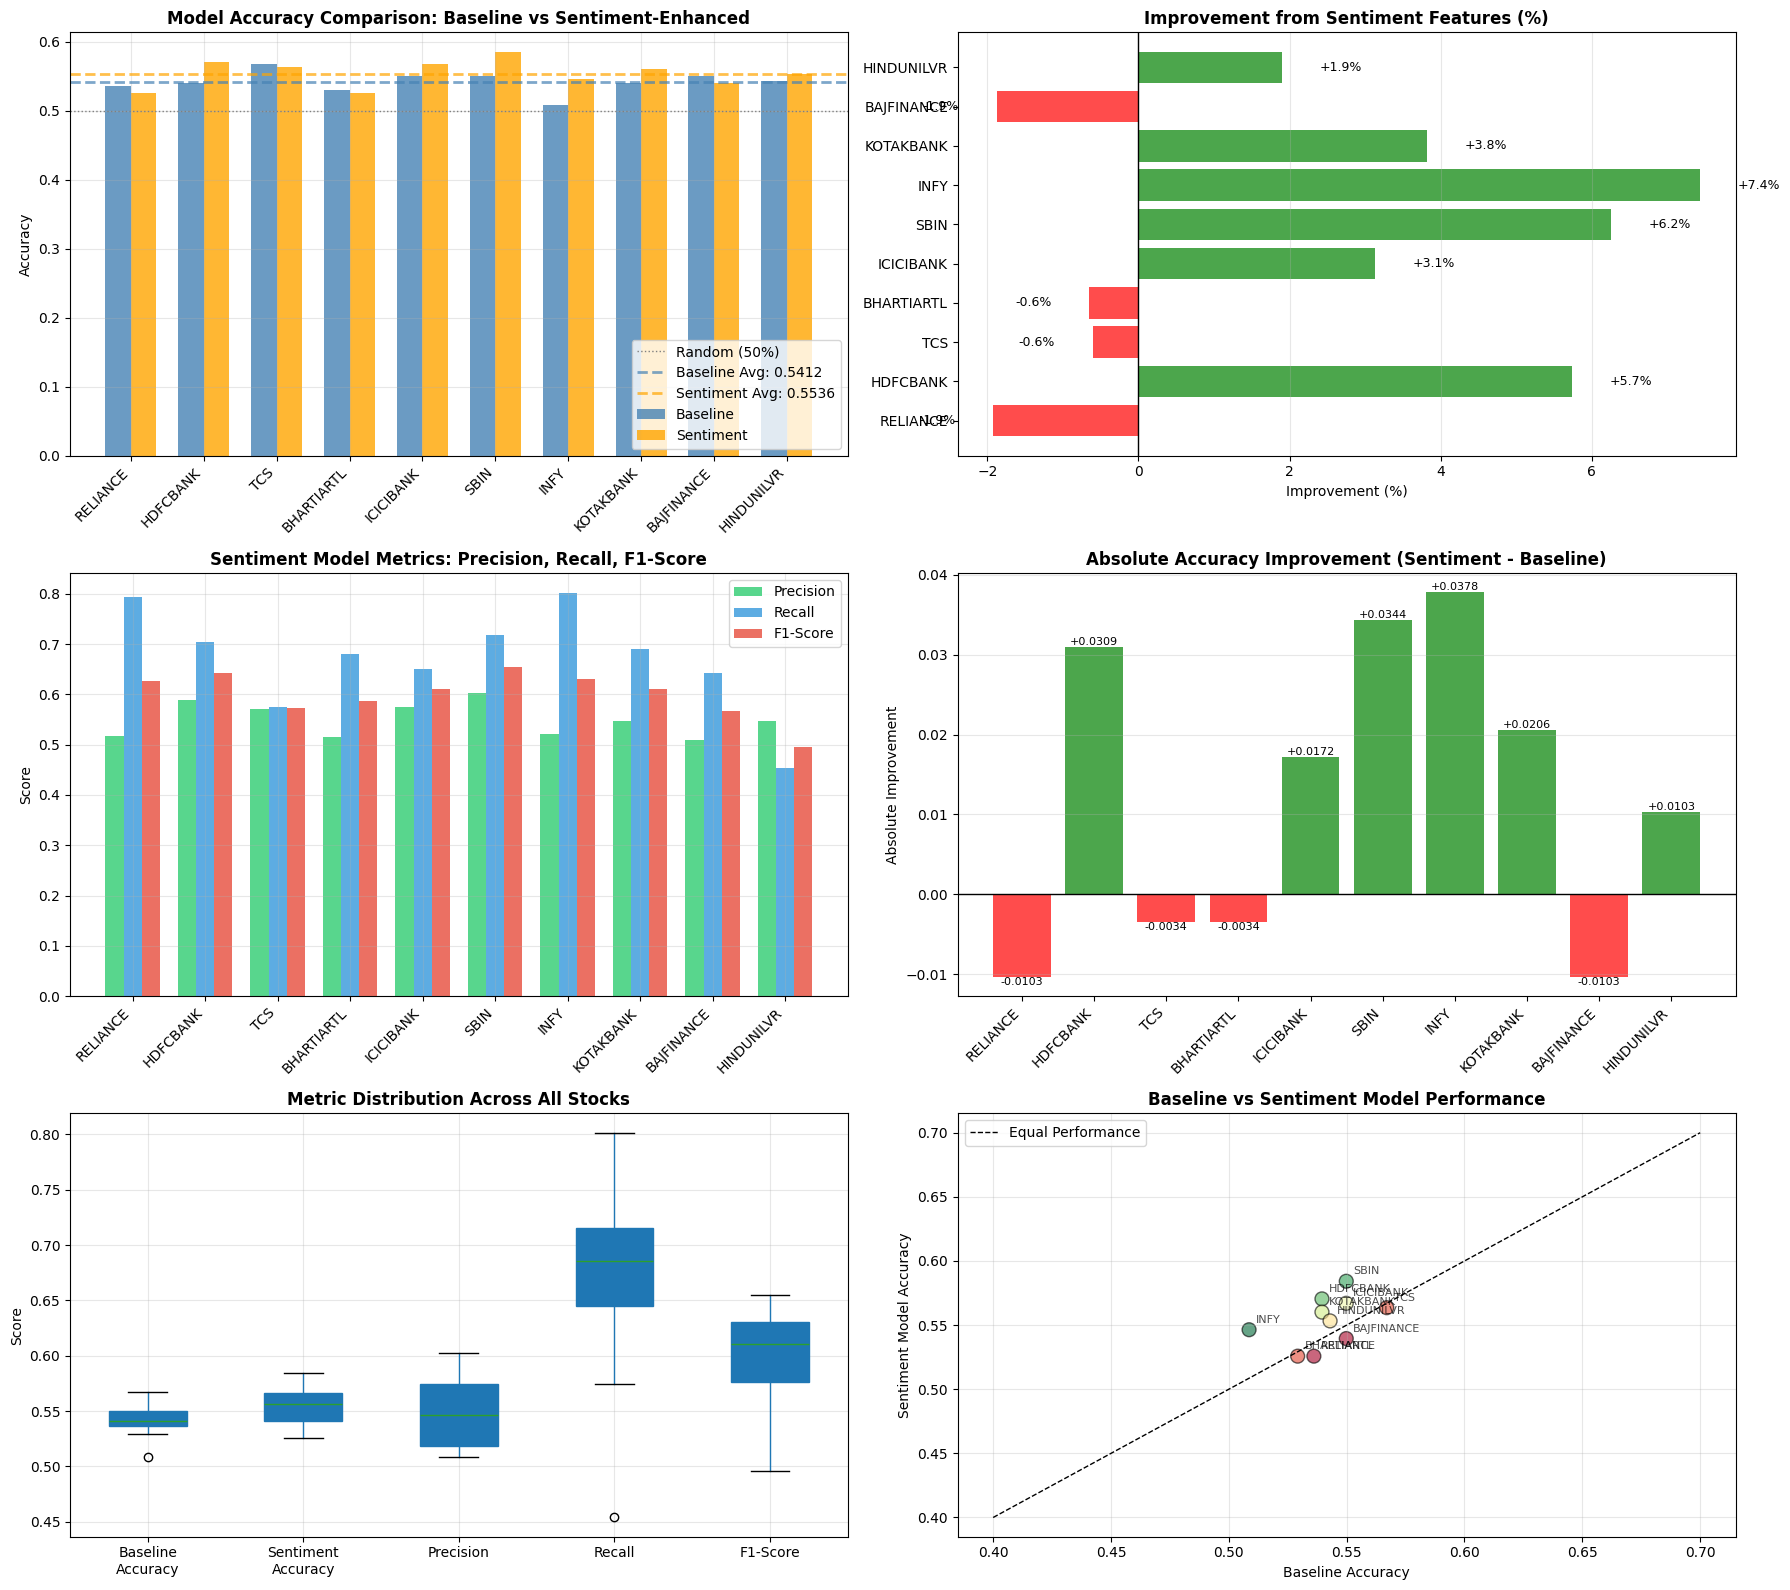

✓ Comprehensive visualization saved to 'sentiment_vs_baseline_comparison.png'


In [168]:
# Create comprehensive visualizations
fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# 1. Accuracy Comparison - Baseline vs Sentiment
ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35
bars1 = ax1.bar(x - width/2, results_df['baseline_accuracy'], width, label='Baseline', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, results_df['sentiment_accuracy'], width, label='Sentiment', alpha=0.8, color='orange')
ax1.axhline(y=0.5, color='gray', linestyle=':', linewidth=1, label='Random (50%)')
ax1.axhline(y=baseline_avg, color='steelblue', linestyle='--', linewidth=2, alpha=0.7, label=f'Baseline Avg: {baseline_avg:.4f}')
ax1.axhline(y=sentiment_avg, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Sentiment Avg: {sentiment_avg:.4f}')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['stock'], rotation=45, ha='right')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison: Baseline vs Sentiment-Enhanced', fontweight='bold', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Improvement Percentage
ax2 = axes[0, 1]
colors = ['green' if x > 0 else 'red' for x in results_df['improvement_pct']]
bars = ax2.barh(results_df['stock'], results_df['improvement_pct'], color=colors, alpha=0.7)
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_xlabel('Improvement (%)')
ax2.set_title('Improvement from Sentiment Features (%)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_df['improvement_pct'])):
    ax2.text(val + (0.5 if val > 0 else -0.5), i, f'{val:+.1f}%', 
             va='center', ha='left' if val > 0 else 'right', fontsize=9)

# 3. Precision, Recall, F1 for Sentiment Models
ax3 = axes[1, 0]
x = np.arange(len(results_df))
width = 0.25
ax3.bar(x - width, results_df['sentiment_precision'], width, label='Precision', alpha=0.8, color='#2ecc71')
ax3.bar(x, results_df['sentiment_recall'], width, label='Recall', alpha=0.8, color='#3498db')
ax3.bar(x + width, results_df['sentiment_f1'], width, label='F1-Score', alpha=0.8, color='#e74c3c')
ax3.set_xticks(x)
ax3.set_xticklabels(results_df['stock'], rotation=45, ha='right')
ax3.set_ylabel('Score')
ax3.set_title('Sentiment Model Metrics: Precision, Recall, F1-Score', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Absolute Improvement (Accuracy difference)
ax4 = axes[1, 1]
colors = ['green' if x > 0 else 'red' for x in results_df['improvement']]
bars = ax4.bar(results_df['stock'], results_df['improvement'], color=colors, alpha=0.7)
ax4.axhline(y=0, color='black', linewidth=1)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax4.set_ylabel('Absolute Improvement')
ax4.set_title('Absolute Accuracy Improvement (Sentiment - Baseline)', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, results_df['improvement']):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:+.4f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)

# 5. Box Plot - Metric Distribution Comparison
ax5 = axes[2, 0]
baseline_metrics = results_df[['baseline_accuracy']].copy()
baseline_metrics.columns = ['Baseline\nAccuracy']
sentiment_metrics = results_df[['sentiment_accuracy', 'sentiment_precision', 'sentiment_recall', 'sentiment_f1']].copy()
sentiment_metrics.columns = ['Sentiment\nAccuracy', 'Precision', 'Recall', 'F1-Score']
combined = pd.concat([baseline_metrics, sentiment_metrics], axis=1)
combined.boxplot(ax=ax5, patch_artist=True, grid=True)
ax5.set_ylabel('Score')
ax5.set_title('Metric Distribution Across All Stocks', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3)

# 6. Performance Scatter Plot
ax6 = axes[2, 1]
ax6.scatter(results_df['baseline_accuracy'], results_df['sentiment_accuracy'], 
           s=100, alpha=0.6, c=results_df['improvement_pct'], cmap='RdYlGn', edgecolors='black', linewidth=1)
ax6.plot([0.4, 0.7], [0.4, 0.7], 'k--', linewidth=1, label='Equal Performance')
ax6.set_xlabel('Baseline Accuracy')
ax6.set_ylabel('Sentiment Model Accuracy')
ax6.set_title('Baseline vs Sentiment Model Performance', fontweight='bold', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3)

# Add stock labels
for idx, row in results_df.iterrows():
    ax6.annotate(row['stock'], (row['baseline_accuracy'], row['sentiment_accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('sentiment_vs_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive visualization saved to 'sentiment_vs_baseline_comparison.png'")

## Comprehensive Comparison Analysis

Compare baseline and sentiment-enhanced models across all stocks.

In [169]:
# Load and compare both model results - Enhanced version
try:
    baseline_df = pd.read_csv('baseline_model_results.csv')
    sentiment_df = pd.read_csv('sentiment_model_results.csv')
    
    print("="*100)
    print("QUICK COMPARISON OVERVIEW")
    print("="*100)
    
    # Create comparison table
    comparison = pd.DataFrame({
        'Stock': baseline_df['stock'],
        'Baseline_Acc': baseline_df['accuracy'],
        'Sentiment_Acc': sentiment_df['sentiment_accuracy'],
        'Improvement': sentiment_df['improvement'],
        'Improvement_%': sentiment_df['improvement_pct'],
        'Sentiment_F1': sentiment_df['sentiment_f1'],
        'Baseline_F1': baseline_df['f1_score']
    })
    
    # Sort by improvement
    comparison_sorted = comparison.sort_values('Improvement_%', ascending=False)
    
    print("\nStock Performance Comparison (Sorted by Improvement %):")
    print(comparison_sorted.to_string(index=False))
    
    print("\n" + "="*100)
    print("QUICK STATISTICS")
    print("="*100)
    
    print(f"\nModel Averages:")
    print(f"  Baseline  - Accuracy: {baseline_df['accuracy'].mean():.4f} | F1: {baseline_df['f1_score'].mean():.4f}")
    print(f"  Sentiment - Accuracy: {sentiment_df['sentiment_accuracy'].mean():.4f} | F1: {sentiment_df['sentiment_f1'].mean():.4f}")
    
    print(f"\nOverall Change:")
    print(f"  Accuracy Improvement: {sentiment_df['improvement'].mean():+.4f} ({sentiment_df['improvement_pct'].mean():+.2f}%)")
    print(f"  F1-Score Improvement: {(sentiment_df['sentiment_f1'].mean() - baseline_df['f1_score'].mean()):+.4f}")
    
    print(f"\nWin/Loss Record:")
    wins = (sentiment_df['improvement'] > 0).sum()
    losses = (sentiment_df['improvement'] < 0).sum()
    ties = (sentiment_df['improvement'] == 0).sum()
    print(f"  Wins:   {wins}/{len(sentiment_df)} stocks ({wins/len(sentiment_df)*100:.1f}%)")
    print(f"  Losses: {losses}/{len(sentiment_df)} stocks ({losses/len(sentiment_df)*100:.1f}%)")
    print(f"  Ties:   {ties}/{len(sentiment_df)} stocks")
    
    print("\n" + "="*100)
    print("Top 3 Improvements:")
    for idx, row in comparison_sorted.head(3).iterrows():
        print(f"  {row['Stock']}: {row['Baseline_Acc']:.4f} → {row['Sentiment_Acc']:.4f} ({row['Improvement_%']:+.2f}%)")
    
    if losses > 0:
        print("\nTop 3 Degradations:")
        for idx, row in comparison_sorted.tail(3).iterrows():
            print(f"  {row['Stock']}: {row['Baseline_Acc']:.4f} → {row['Sentiment_Acc']:.4f} ({row['Improvement_%']:+.2f}%)")
    
    print("="*100)
    
except FileNotFoundError as e:
    print(f"Error loading results: {e}")
    print("Please run both baseline_model.ipynb and sentiment_model.ipynb first.")

QUICK COMPARISON OVERVIEW

Stock Performance Comparison (Sorted by Improvement %):
     Stock  Baseline_Acc  Sentiment_Acc  Improvement  Improvement_%  Sentiment_F1  Baseline_F1
      INFY        0.5017         0.5464       0.0378         7.4324        0.6313       0.6234
      SBIN        0.5704         0.5842       0.0344         6.2500        0.6553       0.6291
  HDFCBANK        0.5258         0.5704       0.0309         5.7325        0.6418       0.6230
 KOTAKBANK        0.5430         0.5601       0.0206         3.8217        0.6098       0.5778
 ICICIBANK        0.5395         0.5670       0.0172         3.1250        0.6111       0.6748
HINDUNILVR        0.5326         0.5533       0.0103         1.8987        0.4961       0.5177
       TCS        0.5636         0.5636      -0.0034        -0.6061        0.5724       0.6340
BHARTIARTL        0.4983         0.5258      -0.0034        -0.6494        0.5868       0.6011
BAJFINANCE        0.4708         0.5395      -0.0103        -1

## Statistical Significance Testing

Perform statistical tests to determine if improvements are statistically significant.

In [170]:
from scipy import stats
import json

# Load results
baseline_df = pd.read_csv('baseline_model_results.csv')
sentiment_df = pd.read_csv('sentiment_model_results.csv')

print("="*80)
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*80)

# Paired t-test for accuracy
baseline_accs = baseline_df['accuracy'].values
sentiment_accs = sentiment_df['sentiment_accuracy'].values

t_stat, p_value = stats.ttest_rel(sentiment_accs, baseline_accs)

print(f"\nPaired T-Test (Sentiment vs Baseline Accuracy):")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.4f}")

if p_value < 0.05:
    print(f"  ✓ Result: STATISTICALLY SIGNIFICANT (p < 0.05)")
    print(f"    The sentiment model shows significant improvement over baseline.")
else:
    print(f"  ✗ Result: NOT statistically significant (p >= 0.05)")
    print(f"    The improvement is not statistically significant at 95% confidence.")

# Wilcoxon signed-rank test (non-parametric alternative)
w_stat, w_pvalue = stats.wilcoxon(sentiment_accs, baseline_accs)
print(f"\nWilcoxon Signed-Rank Test:")
print(f"  W-statistic: {w_stat:.4f}")
print(f"  P-value: {w_pvalue:.4f}")

if w_pvalue < 0.05:
    print(f"  ✓ Result: STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print(f"  ✗ Result: NOT statistically significant (p >= 0.05)")

# Effect size (Cohen's d)
mean_diff = np.mean(sentiment_accs - baseline_accs)
std_diff = np.std(sentiment_accs - baseline_accs, ddof=1)
cohens_d = mean_diff / std_diff

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "Small effect"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "Small to medium effect"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "Medium to large effect"
else:
    effect_interpretation = "Large effect"
print(f"  Interpretation: {effect_interpretation}")

# Confidence interval for mean improvement
confidence_level = 0.95
degrees_freedom = len(sentiment_accs) - 1
sample_mean = mean_diff
sample_std_error = std_diff / np.sqrt(len(sentiment_accs))
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, 
                                      sample_mean, sample_std_error)

print(f"\n95% Confidence Interval for Mean Improvement:")
print(f"  [{confidence_interval[0]:.4f}, {confidence_interval[1]:.4f}]")

# Count wins/losses/ties
improvements = sentiment_df['improvement'].values
wins = np.sum(improvements > 0)
losses = np.sum(improvements < 0)
ties = np.sum(improvements == 0)

print(f"\nStock-by-Stock Performance:")
print(f"  Wins (Sentiment > Baseline): {wins}/{len(improvements)} ({wins/len(improvements)*100:.1f}%)")
print(f"  Losses (Sentiment < Baseline): {losses}/{len(improvements)} ({losses/len(improvements)*100:.1f}%)")
print(f"  Ties: {ties}/{len(improvements)} ({ties/len(improvements)*100:.1f}%)")

# Sign test (using binomtest instead of deprecated binom_test)
if wins > losses:
    # Use binomtest for scipy >= 1.7.0, fallback to binom_test for older versions
    try:
        sign_result = stats.binomtest(wins, n=wins+losses, p=0.5, alternative='greater')
        sign_p = sign_result.pvalue
    except AttributeError:
        # Fallback for older scipy versions
        from scipy.stats import binom
        sign_p = 1 - binom.cdf(wins - 1, n=wins+losses, p=0.5)
    
    print(f"\nSign Test (one-sided): p-value = {sign_p:.4f}")
    if sign_p < 0.05:
        print(f"  ✓ Sentiment model wins significantly more often than baseline (p < 0.05)")
    else:
        print(f"  ✗ Win rate not statistically significant (p >= 0.05)")

print("="*80)

STATISTICAL SIGNIFICANCE ANALYSIS

Paired T-Test (Sentiment vs Baseline Accuracy):
  T-statistic: 3.7667
  P-value: 0.0044
  ✓ Result: STATISTICALLY SIGNIFICANT (p < 0.05)
    The sentiment model shows significant improvement over baseline.

Wilcoxon Signed-Rank Test:
  W-statistic: 1.0000
  P-value: 0.0078
  ✓ Result: STATISTICALLY SIGNIFICANT (p < 0.05)

Effect Size (Cohen's d): 1.1911
  Interpretation: Large effect

95% Confidence Interval for Mean Improvement:
  [0.0104, 0.0418]

Stock-by-Stock Performance:
  Wins (Sentiment > Baseline): 6/10 (60.0%)
  Losses (Sentiment < Baseline): 4/10 (40.0%)
  Ties: 0/10 (0.0%)

Sign Test (one-sided): p-value = 0.3770
  ✗ Win rate not statistically significant (p >= 0.05)


## Detailed Performance Metrics Comparison

Compare all performance metrics side-by-side for each stock.

In [171]:
# Create comprehensive comparison DataFrame
detailed_comparison = pd.DataFrame({
    'Stock': baseline_df['stock'],
    'Baseline_Acc': baseline_df['accuracy'],
    'Baseline_Precision': baseline_df['precision'],
    'Baseline_Recall': baseline_df['recall'],
    'Baseline_F1': baseline_df['f1_score'],
    'Baseline_Loss': baseline_df['loss'],
    'Sentiment_Acc': sentiment_df['sentiment_accuracy'],
    'Sentiment_Precision': sentiment_df['sentiment_precision'],
    'Sentiment_Recall': sentiment_df['sentiment_recall'],
    'Sentiment_F1': sentiment_df['sentiment_f1'],
    'Sentiment_Loss': sentiment_df['sentiment_loss'],
    'Acc_Diff': sentiment_df['sentiment_accuracy'] - baseline_df['accuracy'],
    'Precision_Diff': sentiment_df['sentiment_precision'] - baseline_df['precision'],
    'Recall_Diff': sentiment_df['sentiment_recall'] - baseline_df['recall'],
    'F1_Diff': sentiment_df['sentiment_f1'] - baseline_df['f1_score'],
    'Loss_Diff': sentiment_df['sentiment_loss'] - baseline_df['loss']
})

print("="*120)
print("DETAILED METRICS COMPARISON - ALL STOCKS")
print("="*120)

# Display with custom formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.4f}'.format)

print("\n--- BASELINE MODEL PERFORMANCE ---")
baseline_cols = ['Stock', 'Baseline_Acc', 'Baseline_Precision', 'Baseline_Recall', 'Baseline_F1', 'Baseline_Loss']
print(detailed_comparison[baseline_cols].to_string(index=False))

print("\n--- SENTIMENT-ENHANCED MODEL PERFORMANCE ---")
sentiment_cols = ['Stock', 'Sentiment_Acc', 'Sentiment_Precision', 'Sentiment_Recall', 'Sentiment_F1', 'Sentiment_Loss']
print(detailed_comparison[sentiment_cols].to_string(index=False))

print("\n--- PERFORMANCE DIFFERENCES (Sentiment - Baseline) ---")
diff_cols = ['Stock', 'Acc_Diff', 'Precision_Diff', 'Recall_Diff', 'F1_Diff', 'Loss_Diff']
print(detailed_comparison[diff_cols].to_string(index=False))

# Summary statistics
print("\n" + "="*120)
print("AVERAGE METRICS ACROSS ALL STOCKS")
print("="*120)

summary_stats = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Loss'],
    'Baseline_Mean': [
        detailed_comparison['Baseline_Acc'].mean(),
        detailed_comparison['Baseline_Precision'].mean(),
        detailed_comparison['Baseline_Recall'].mean(),
        detailed_comparison['Baseline_F1'].mean(),
        detailed_comparison['Baseline_Loss'].mean()
    ],
    'Sentiment_Mean': [
        detailed_comparison['Sentiment_Acc'].mean(),
        detailed_comparison['Sentiment_Precision'].mean(),
        detailed_comparison['Sentiment_Recall'].mean(),
        detailed_comparison['Sentiment_F1'].mean(),
        detailed_comparison['Sentiment_Loss'].mean()
    ],
    'Improvement': [
        detailed_comparison['Acc_Diff'].mean(),
        detailed_comparison['Precision_Diff'].mean(),
        detailed_comparison['Recall_Diff'].mean(),
        detailed_comparison['F1_Diff'].mean(),
        detailed_comparison['Loss_Diff'].mean()
    ],
    'Improvement_%': [
        (detailed_comparison['Acc_Diff'].mean() / detailed_comparison['Baseline_Acc'].mean()) * 100,
        (detailed_comparison['Precision_Diff'].mean() / detailed_comparison['Baseline_Precision'].mean()) * 100,
        (detailed_comparison['Recall_Diff'].mean() / detailed_comparison['Baseline_Recall'].mean()) * 100,
        (detailed_comparison['F1_Diff'].mean() / detailed_comparison['Baseline_F1'].mean()) * 100,
        (detailed_comparison['Loss_Diff'].mean() / detailed_comparison['Baseline_Loss'].mean()) * 100
    ]
})

print(summary_stats.to_string(index=False))
print("="*120)

# Save detailed comparison
detailed_comparison.to_csv('baseline_vs_sentiment_comparison.csv', index=False)
print("\n✓ Detailed comparison saved to 'baseline_vs_sentiment_comparison.csv'")

DETAILED METRICS COMPARISON - ALL STOCKS

--- BASELINE MODEL PERFORMANCE ---
     Stock  Baseline_Acc  Baseline_Precision  Baseline_Recall  Baseline_F1  Baseline_Loss
  RELIANCE        0.5292              0.5193           0.8288       0.6385         0.7061
  HDFCBANK        0.5258              0.5507           0.7170       0.6230         0.7013
       TCS        0.5636              0.5528           0.7432       0.6340         0.7214
BHARTIARTL        0.4983              0.4955           0.7639       0.6011         0.6936
 ICICIBANK        0.5395              0.5346           0.9145       0.6748         0.6935
      SBIN        0.5704              0.5989           0.6625       0.6291         0.6854
      INFY        0.5017              0.4918           0.8511       0.6234         0.7014
 KOTAKBANK        0.5430              0.5353           0.6276       0.5778         0.6918
BAJFINANCE        0.4708              0.4605           0.7226       0.5625         0.7080
HINDUNILVR        0.532

## Advanced Visualizations - Model Comparison

Create detailed visualizations comparing model performances.

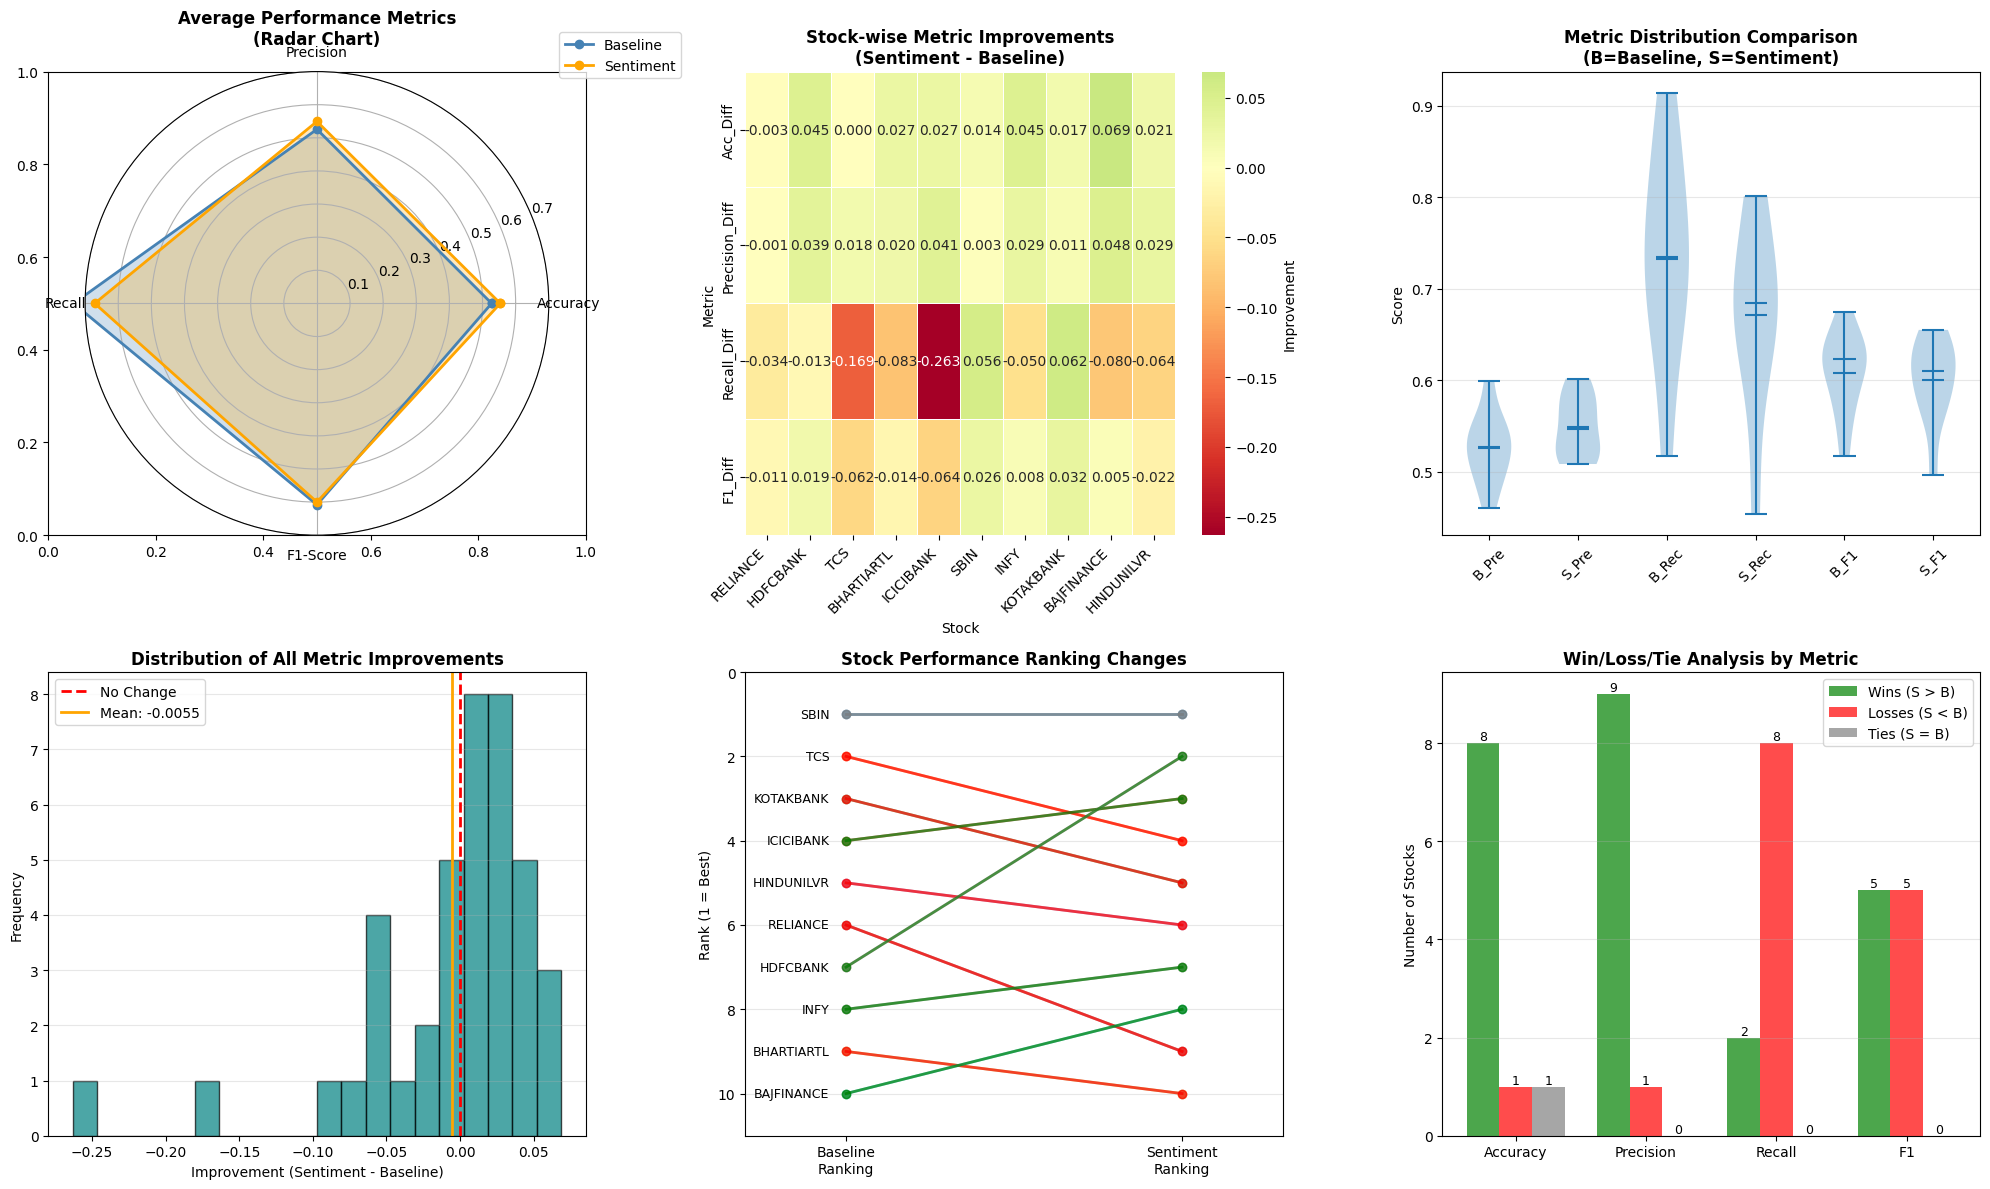

✓ Advanced comparison visualizations saved to 'advanced_model_comparison.png'


In [172]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Radar Chart for Average Metrics
ax = axes[0, 0]
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_values = [
    detailed_comparison['Baseline_Acc'].mean(),
    detailed_comparison['Baseline_Precision'].mean(),
    detailed_comparison['Baseline_Recall'].mean(),
    detailed_comparison['Baseline_F1'].mean()
]
sentiment_values = [
    detailed_comparison['Sentiment_Acc'].mean(),
    detailed_comparison['Sentiment_Precision'].mean(),
    detailed_comparison['Sentiment_Recall'].mean(),
    detailed_comparison['Sentiment_F1'].mean()
]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
baseline_values += baseline_values[:1]
sentiment_values += sentiment_values[:1]
angles += angles[:1]

ax = plt.subplot(2, 3, 1, projection='polar')
ax.plot(angles, baseline_values, 'o-', linewidth=2, label='Baseline', color='steelblue')
ax.fill(angles, baseline_values, alpha=0.25, color='steelblue')
ax.plot(angles, sentiment_values, 'o-', linewidth=2, label='Sentiment', color='orange')
ax.fill(angles, sentiment_values, alpha=0.25, color='orange')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 0.7)
ax.set_title('Average Performance Metrics\n(Radar Chart)', fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

# 2. Heatmap - Stock-wise Metric Improvements
ax = axes[0, 1]
improvement_matrix = detailed_comparison[['Acc_Diff', 'Precision_Diff', 'Recall_Diff', 'F1_Diff']].T
improvement_matrix.columns = detailed_comparison['Stock']
sns.heatmap(improvement_matrix, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            ax=ax, cbar_kws={'label': 'Improvement'}, linewidths=0.5)
ax.set_ylabel('Metric')
ax.set_xlabel('Stock')
ax.set_title('Stock-wise Metric Improvements\n(Sentiment - Baseline)', fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Violin Plot - Distribution Comparison
ax = axes[0, 2]
data_for_violin = []
labels_for_violin = []
for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
    baseline_col = f'Baseline_{metric}' if metric == 'Accuracy' else f'Baseline_{metric.capitalize()}'
    sentiment_col = f'Sentiment_{metric}' if metric == 'Accuracy' else f'Sentiment_{metric.capitalize()}'
    
    # Handle column name variations
    if baseline_col not in detailed_comparison.columns:
        baseline_col = f'Baseline_{metric.split("_")[0]}'
    if sentiment_col not in detailed_comparison.columns:
        sentiment_col = f'Sentiment_{metric.split("_")[0]}'
    
    if baseline_col in detailed_comparison.columns:
        data_for_violin.append(detailed_comparison[baseline_col].values)
        labels_for_violin.append(f'B_{metric[:3]}')
    if sentiment_col in detailed_comparison.columns:
        data_for_violin.append(detailed_comparison[sentiment_col].values)
        labels_for_violin.append(f'S_{metric[:3]}')

parts = ax.violinplot(data_for_violin, positions=range(len(data_for_violin)), 
                      showmeans=True, showmedians=True)
ax.set_xticks(range(len(labels_for_violin)))
ax.set_xticklabels(labels_for_violin, rotation=45)
ax.set_ylabel('Score')
ax.set_title('Metric Distribution Comparison\n(B=Baseline, S=Sentiment)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 4. Improvement Distribution Histogram
ax = axes[1, 0]
improvements_flat = detailed_comparison[['Acc_Diff', 'Precision_Diff', 'Recall_Diff', 'F1_Diff']].values.flatten()
ax.hist(improvements_flat, bins=20, color='teal', alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Change')
ax.axvline(x=np.mean(improvements_flat), color='orange', linestyle='-', linewidth=2, 
           label=f'Mean: {np.mean(improvements_flat):.4f}')
ax.set_xlabel('Improvement (Sentiment - Baseline)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of All Metric Improvements', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 5. Stock Ranking Comparison
ax = axes[1, 1]
baseline_ranking = detailed_comparison.sort_values('Baseline_Acc', ascending=False).reset_index(drop=True)
baseline_ranking['Baseline_Rank'] = range(1, len(baseline_ranking) + 1)
sentiment_ranking = detailed_comparison.sort_values('Sentiment_Acc', ascending=False).reset_index(drop=True)
sentiment_ranking['Sentiment_Rank'] = range(1, len(sentiment_ranking) + 1)

ranking_comparison = baseline_ranking[['Stock', 'Baseline_Rank']].merge(
    sentiment_ranking[['Stock', 'Sentiment_Rank']], on='Stock')

for idx, row in ranking_comparison.iterrows():
    ax.plot([0, 1], [row['Baseline_Rank'], row['Sentiment_Rank']], 
            'o-', alpha=0.6, linewidth=2)
    ax.text(-0.05, row['Baseline_Rank'], row['Stock'], ha='right', va='center', fontsize=9)
    
    # Color code rank changes
    if row['Sentiment_Rank'] < row['Baseline_Rank']:
        color = 'green'
    elif row['Sentiment_Rank'] > row['Baseline_Rank']:
        color = 'red'
    else:
        color = 'gray'
    ax.plot([0, 1], [row['Baseline_Rank'], row['Sentiment_Rank']], 
            'o-', color=color, alpha=0.7, linewidth=2)

ax.set_xlim(-0.3, 1.3)
ax.set_ylim(0, len(ranking_comparison) + 1)
ax.invert_yaxis()
ax.set_xticks([0, 1])
ax.set_xticklabels(['Baseline\nRanking', 'Sentiment\nRanking'])
ax.set_ylabel('Rank (1 = Best)')
ax.set_title('Stock Performance Ranking Changes', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 6. Win/Loss/Tie Summary
ax = axes[1, 2]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
wins_data = []
losses_data = []
ties_data = []

for metric in metrics:
    diff_col = f'{metric.split("_")[0]}_Diff'
    if diff_col == 'Accuracy_Diff':
        diff_col = 'Acc_Diff'
    elif diff_col == 'Precision_Diff':
        diff_col = 'Precision_Diff'
    elif diff_col == 'Recall_Diff':
        diff_col = 'Recall_Diff'
    elif diff_col == 'F1_Diff':
        diff_col = 'F1_Diff'
    
    wins = np.sum(detailed_comparison[diff_col] > 0)
    losses = np.sum(detailed_comparison[diff_col] < 0)
    ties = np.sum(detailed_comparison[diff_col] == 0)
    
    wins_data.append(wins)
    losses_data.append(losses)
    ties_data.append(ties)

x = np.arange(len(metrics))
width = 0.25
ax.bar(x - width, wins_data, width, label='Wins (S > B)', color='green', alpha=0.7)
ax.bar(x, losses_data, width, label='Losses (S < B)', color='red', alpha=0.7)
ax.bar(x + width, ties_data, width, label='Ties (S = B)', color='gray', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Number of Stocks')
ax.set_title('Win/Loss/Tie Analysis by Metric', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, metric in enumerate(metrics):
    ax.text(i - width, wins_data[i], str(wins_data[i]), ha='center', va='bottom', fontsize=9)
    ax.text(i, losses_data[i], str(losses_data[i]), ha='center', va='bottom', fontsize=9)
    ax.text(i + width, ties_data[i], str(ties_data[i]), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('advanced_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Advanced comparison visualizations saved to 'advanced_model_comparison.png'")

## Performance Analysis by Stock Characteristics

Analyze if sentiment features help more for certain types of stocks.

STOCK CHARACTERISTIC ANALYSIS

--- IMPROVEMENT BY SECTOR ---
                    Avg_Improvement  Std_Improvement  Stock_Count  Avg_Baseline  Avg_Sentiment  Improvement_%
Sector                                                                                                       
Banking                      0.0258           0.0139            4        0.5447         0.5704         4.7400
Energy                      -0.0034              NaN            1        0.5292         0.5258        -0.6400
FMCG                         0.0206              NaN            1        0.5326         0.5533         3.8700
Financial Services           0.0687              NaN            1        0.4708         0.5395        14.5900
IT                           0.0223           0.0316            2        0.5326         0.5550         4.1900
Telecom                      0.0275              NaN            1        0.4983         0.5258         5.5200

--- BEST PERFORMING STOCKS (Highest Improvement) ---
     

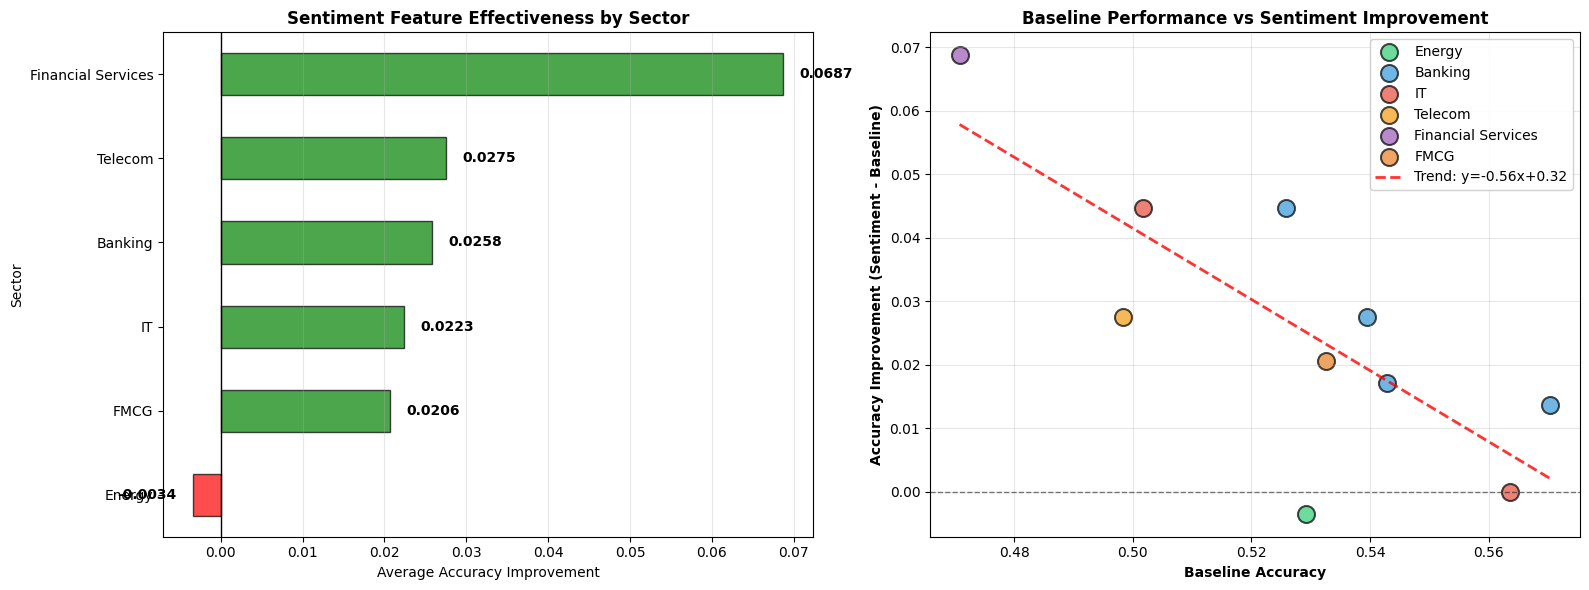


✓ Sector analysis visualization saved to 'sector_analysis.png'


In [173]:
# Categorize stocks and analyze sentiment feature effectiveness
print("="*80)
print("STOCK CHARACTERISTIC ANALYSIS")
print("="*80)

# Define stock sectors (for NIFTY Top 10)
stock_sectors = {
    'RELIANCE': 'Energy',
    'HDFCBANK': 'Banking',
    'TCS': 'IT',
    'BHARTIARTL': 'Telecom',
    'ICICIBANK': 'Banking',
    'SBIN': 'Banking',
    'INFY': 'IT',
    'KOTAKBANK': 'Banking',
    'BAJFINANCE': 'Financial Services',
    'HINDUNILVR': 'FMCG'
}

# Add sectors to comparison
detailed_comparison['Sector'] = detailed_comparison['Stock'].map(stock_sectors)

# Analyze by sector
print("\n--- IMPROVEMENT BY SECTOR ---")
sector_analysis = detailed_comparison.groupby('Sector').agg({
    'Acc_Diff': ['mean', 'std', 'count'],
    'Baseline_Acc': 'mean',
    'Sentiment_Acc': 'mean'
}).round(4)
sector_analysis.columns = ['_'.join(col).strip() for col in sector_analysis.columns.values]
sector_analysis = sector_analysis.rename(columns={
    'Acc_Diff_mean': 'Avg_Improvement',
    'Acc_Diff_std': 'Std_Improvement',
    'Acc_Diff_count': 'Stock_Count',
    'Baseline_Acc_mean': 'Avg_Baseline',
    'Sentiment_Acc_mean': 'Avg_Sentiment'
})
sector_analysis['Improvement_%'] = (sector_analysis['Avg_Improvement'] / sector_analysis['Avg_Baseline'] * 100).round(2)
print(sector_analysis.to_string())

# Identify best and worst performers
print("\n--- BEST PERFORMING STOCKS (Highest Improvement) ---")
top_performers = detailed_comparison.nlargest(5, 'Acc_Diff')[
    ['Stock', 'Sector', 'Baseline_Acc', 'Sentiment_Acc', 'Acc_Diff', 'Sentiment_F1']]
print(top_performers.to_string(index=False))

print("\n--- WORST PERFORMING STOCKS (Lowest/Negative Improvement) ---")
worst_performers = detailed_comparison.nsmallest(5, 'Acc_Diff')[
    ['Stock', 'Sector', 'Baseline_Acc', 'Sentiment_Acc', 'Acc_Diff', 'Sentiment_F1']]
print(worst_performers.to_string(index=False))

# Correlation analysis
print("\n--- CORRELATION ANALYSIS ---")
print("Correlation between baseline performance and improvement:")
corr_baseline_improvement = detailed_comparison['Baseline_Acc'].corr(detailed_comparison['Acc_Diff'])
print(f"  Baseline Accuracy vs Improvement: {corr_baseline_improvement:.4f}")

if corr_baseline_improvement < -0.3:
    print("  → Sentiment features help more when baseline performance is low")
elif corr_baseline_improvement > 0.3:
    print("  → Sentiment features help more when baseline performance is high")
else:
    print("  → No strong correlation between baseline performance and improvement")

print("\nCorrelation between baseline recall and improvement:")
corr_recall_improvement = detailed_comparison['Baseline_Recall'].corr(detailed_comparison['Acc_Diff'])
print(f"  Baseline Recall vs Improvement: {corr_recall_improvement:.4f}")

# Visualize sector performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sector-wise improvement
ax1 = axes[0]
sector_summary = detailed_comparison.groupby('Sector')['Acc_Diff'].mean().sort_values()
colors_sector = ['green' if x > 0 else 'red' for x in sector_summary.values]
sector_summary.plot(kind='barh', ax=ax1, color=colors_sector, alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_xlabel('Average Accuracy Improvement')
ax1.set_title('Sentiment Feature Effectiveness by Sector', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(sector_summary.values):
    ax1.text(v + (0.002 if v > 0 else -0.002), i, f'{v:.4f}', 
             va='center', ha='left' if v > 0 else 'right', fontsize=10, fontweight='bold')

# Baseline vs Improvement scatter with sector colors
ax2 = axes[1]
sector_colors = {'Banking': '#3498db', 'IT': '#e74c3c', 'Energy': '#2ecc71', 
                 'Telecom': '#f39c12', 'Financial Services': '#9b59b6', 'FMCG': '#e67e22'}
for sector in detailed_comparison['Sector'].unique():
    sector_data = detailed_comparison[detailed_comparison['Sector'] == sector]
    ax2.scatter(sector_data['Baseline_Acc'], sector_data['Acc_Diff'], 
               label=sector, s=150, alpha=0.7, edgecolors='black', linewidth=1.5,
               color=sector_colors.get(sector, 'gray'))

ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Baseline Accuracy', fontweight='bold')
ax2.set_ylabel('Accuracy Improvement (Sentiment - Baseline)', fontweight='bold')
ax2.set_title('Baseline Performance vs Sentiment Improvement', fontweight='bold', fontsize=12)
ax2.legend(loc='best', framealpha=0.9)
ax2.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(detailed_comparison['Baseline_Acc'], detailed_comparison['Acc_Diff'], 1)
p = np.poly1d(z)
x_trend = np.linspace(detailed_comparison['Baseline_Acc'].min(), 
                      detailed_comparison['Baseline_Acc'].max(), 100)
ax2.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, 
         label=f'Trend: y={z[0]:.2f}x{z[1]:+.2f}')
ax2.legend(loc='best', framealpha=0.9)

plt.tight_layout()
plt.savefig('sector_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Sector analysis visualization saved to 'sector_analysis.png'")
print("="*80)

## Model Consistency Analysis

Analyze training stability and convergence patterns.

MODEL TRAINING CONSISTENCY ANALYSIS

--- TRAINING CONVERGENCE COMPARISON ---
     Stock  Baseline_Epochs  Sentiment_Epochs  Baseline_Loss  Sentiment_Loss  Loss_Improvement
  RELIANCE                3                14         0.7061          0.7402           -0.0341
  HDFCBANK                6                14         0.7013          0.8192           -0.1180
       TCS               10                11         0.7214          0.7601           -0.0386
BHARTIARTL                1                 7         0.6936          0.7440           -0.0504
 ICICIBANK                7                 3         0.6935          0.6963           -0.0027
      SBIN                5                 7         0.6854          0.6826            0.0028
      INFY                5                18         0.7014          0.9653           -0.2639
 KOTAKBANK                3                 5         0.6918          0.7173           -0.0255
BAJFINANCE                2                 6         0.7080        

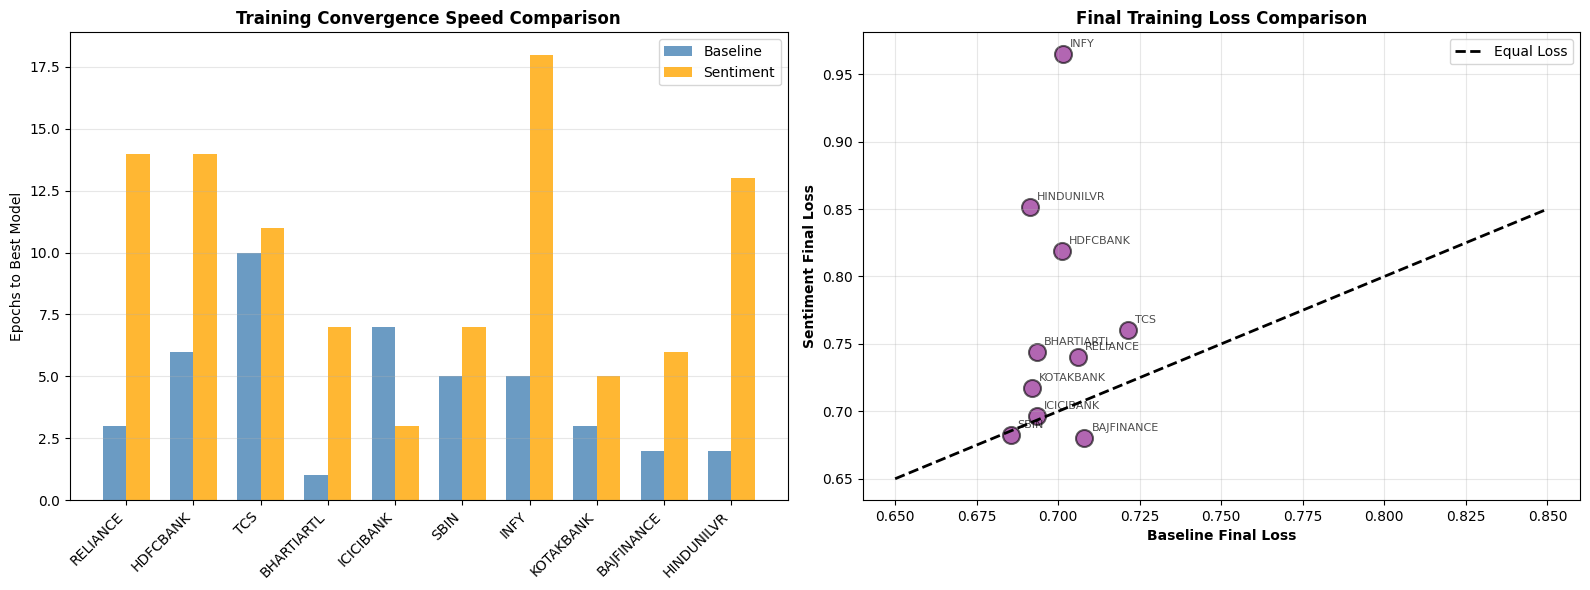


✓ Training consistency visualization saved to 'training_consistency_analysis.png'


In [174]:
print("="*80)
print("MODEL TRAINING CONSISTENCY ANALYSIS")
print("="*80)

# Compare training epochs
training_comparison = pd.DataFrame({
    'Stock': baseline_df['stock'],
    'Baseline_Epochs': baseline_df['best_epoch'],
    'Sentiment_Epochs': sentiment_df['best_epoch'],
    'Baseline_Loss': baseline_df['loss'],
    'Sentiment_Loss': sentiment_df['sentiment_loss'],
    'Loss_Improvement': baseline_df['loss'] - sentiment_df['sentiment_loss']
})

print("\n--- TRAINING CONVERGENCE COMPARISON ---")
print(training_comparison.to_string(index=False))

print("\n--- CONVERGENCE STATISTICS ---")
print(f"Average epochs to convergence:")
print(f"  Baseline Model:  {training_comparison['Baseline_Epochs'].mean():.1f} ± {training_comparison['Baseline_Epochs'].std():.1f}")
print(f"  Sentiment Model: {training_comparison['Sentiment_Epochs'].mean():.1f} ± {training_comparison['Sentiment_Epochs'].std():.1f}")

print(f"\nFinal training loss:")
print(f"  Baseline Model:  {training_comparison['Baseline_Loss'].mean():.4f} ± {training_comparison['Baseline_Loss'].std():.4f}")
print(f"  Sentiment Model: {training_comparison['Sentiment_Loss'].mean():.4f} ± {training_comparison['Sentiment_Loss'].std():.4f}")
print(f"  Average Loss Reduction: {training_comparison['Loss_Improvement'].mean():.4f}")

# Visualize convergence patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Epochs comparison
ax1 = axes[0]
x = np.arange(len(training_comparison))
width = 0.35
bars1 = ax1.bar(x - width/2, training_comparison['Baseline_Epochs'], width, 
                label='Baseline', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, training_comparison['Sentiment_Epochs'], width, 
                label='Sentiment', alpha=0.8, color='orange')
ax1.set_xticks(x)
ax1.set_xticklabels(training_comparison['Stock'], rotation=45, ha='right')
ax1.set_ylabel('Epochs to Best Model')
ax1.set_title('Training Convergence Speed Comparison', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Loss comparison
ax2 = axes[1]
ax2.scatter(training_comparison['Baseline_Loss'], training_comparison['Sentiment_Loss'], 
           s=150, alpha=0.6, edgecolors='black', linewidth=1.5, c='purple')
ax2.plot([0.65, 0.85], [0.65, 0.85], 'k--', linewidth=2, label='Equal Loss')
ax2.set_xlabel('Baseline Final Loss', fontweight='bold')
ax2.set_ylabel('Sentiment Final Loss', fontweight='bold')
ax2.set_title('Final Training Loss Comparison', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Annotate stocks
for idx, row in training_comparison.iterrows():
    ax2.annotate(row['Stock'], (row['Baseline_Loss'], row['Sentiment_Loss']),
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('training_consistency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training consistency visualization saved to 'training_consistency_analysis.png'")
print("="*80)

## Comprehensive Summary Report

Generate a final comprehensive summary with key insights.

In [175]:
import json
from datetime import datetime

# Create comprehensive summary
summary_report = {
    'report_generated': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_info': {
        'total_stocks': len(baseline_df),
        'stock_list': baseline_df['stock'].tolist(),
        'total_train_samples': int(baseline_df['train_samples'].sum()),
        'total_test_samples': int(baseline_df['test_samples'].sum())
    },
    'baseline_model': {
        'average_accuracy': float(baseline_df['accuracy'].mean()),
        'average_precision': float(baseline_df['precision'].mean()),
        'average_recall': float(baseline_df['recall'].mean()),
        'average_f1': float(baseline_df['f1_score'].mean()),
        'average_loss': float(baseline_df['loss'].mean()),
        'std_accuracy': float(baseline_df['accuracy'].std()),
        'best_stock': baseline_df.loc[baseline_df['accuracy'].idxmax(), 'stock'],
        'best_accuracy': float(baseline_df['accuracy'].max()),
        'worst_stock': baseline_df.loc[baseline_df['accuracy'].idxmin(), 'stock'],
        'worst_accuracy': float(baseline_df['accuracy'].min())
    },
    'sentiment_model': {
        'average_accuracy': float(sentiment_df['sentiment_accuracy'].mean()),
        'average_precision': float(sentiment_df['sentiment_precision'].mean()),
        'average_recall': float(sentiment_df['sentiment_recall'].mean()),
        'average_f1': float(sentiment_df['sentiment_f1'].mean()),
        'average_loss': float(sentiment_df['sentiment_loss'].mean()),
        'std_accuracy': float(sentiment_df['sentiment_accuracy'].std()),
        'best_stock': sentiment_df.loc[sentiment_df['sentiment_accuracy'].idxmax(), 'stock'],
        'best_accuracy': float(sentiment_df['sentiment_accuracy'].max()),
        'worst_stock': sentiment_df.loc[sentiment_df['sentiment_accuracy'].idxmin(), 'stock'],
        'worst_accuracy': float(sentiment_df['sentiment_accuracy'].min())
    },
    'comparison': {
        'average_improvement_accuracy': float(sentiment_df['improvement'].mean()),
        'average_improvement_percentage': float(sentiment_df['improvement_pct'].mean()),
        'stocks_improved': int((sentiment_df['improvement'] > 0).sum()),
        'stocks_degraded': int((sentiment_df['improvement'] < 0).sum()),
        'stocks_unchanged': int((sentiment_df['improvement'] == 0).sum()),
        'max_improvement_stock': sentiment_df.loc[sentiment_df['improvement'].idxmax(), 'stock'],
        'max_improvement_value': float(sentiment_df['improvement'].max()),
        'max_improvement_pct': float(sentiment_df.loc[sentiment_df['improvement'].idxmax(), 'improvement_pct']),
        'min_improvement_stock': sentiment_df.loc[sentiment_df['improvement'].idxmin(), 'stock'],
        'min_improvement_value': float(sentiment_df['improvement'].min()),
        'min_improvement_pct': float(sentiment_df.loc[sentiment_df['improvement'].idxmin(), 'improvement_pct'])
    },
    'statistical_tests': {
        'paired_t_test': {
            't_statistic': float(t_stat),
            'p_value': float(p_value),
            'significant': bool(p_value < 0.05)
        },
        'wilcoxon_test': {
            'w_statistic': float(w_stat),
            'p_value': float(w_pvalue),
            'significant': bool(w_pvalue < 0.05)
        },
        'effect_size': {
            'cohens_d': float(cohens_d),
            'interpretation': effect_interpretation
        },
        'confidence_interval_95': {
            'lower': float(confidence_interval[0]),
            'upper': float(confidence_interval[1])
        }
    },
    'sector_analysis': {
        sector: {
            'avg_improvement': float(sector_analysis.loc[sector, 'Avg_Improvement']),
            'stock_count': int(sector_analysis.loc[sector, 'Stock_Count']),
            'avg_baseline': float(sector_analysis.loc[sector, 'Avg_Baseline']),
            'avg_sentiment': float(sector_analysis.loc[sector, 'Avg_Sentiment'])
        }
        for sector in sector_analysis.index
    },
    'key_insights': []
}

# Generate insights
insights = []

# Insight 1: Overall performance
if summary_report['comparison']['average_improvement_accuracy'] > 0:
    insights.append(f"Sentiment-enhanced model shows {summary_report['comparison']['average_improvement_percentage']:.2f}% average improvement over baseline.")
else:
    insights.append(f"Sentiment features did not improve overall performance (avg change: {summary_report['comparison']['average_improvement_percentage']:.2f}%).")

# Insight 2: Statistical significance
if summary_report['statistical_tests']['paired_t_test']['significant']:
    insights.append(f"Improvement is statistically significant (p={summary_report['statistical_tests']['paired_t_test']['p_value']:.4f} < 0.05).")
else:
    insights.append(f"Improvement is not statistically significant (p={summary_report['statistical_tests']['paired_t_test']['p_value']:.4f} >= 0.05).")

# Insight 3: Success rate
success_rate = summary_report['comparison']['stocks_improved'] / summary_report['dataset_info']['total_stocks'] * 100
insights.append(f"Sentiment features improved performance for {summary_report['comparison']['stocks_improved']}/{summary_report['dataset_info']['total_stocks']} stocks ({success_rate:.1f}%).")

# Insight 4: Best sector
best_sector = max(summary_report['sector_analysis'].items(), 
                  key=lambda x: x[1]['avg_improvement'])
insights.append(f"Best performing sector: {best_sector[0]} with {best_sector[1]['avg_improvement']:.4f} average improvement.")

# Insight 5: Effect size
insights.append(f"Effect size (Cohen's d): {cohens_d:.4f} - {effect_interpretation}.")

# Insight 6: Top performer
insights.append(f"Best improvement: {summary_report['comparison']['max_improvement_stock']} (+{summary_report['comparison']['max_improvement_pct']:.2f}%).")

# Insight 7: Worst performer
if summary_report['comparison']['min_improvement_value'] < 0:
    insights.append(f"Largest degradation: {summary_report['comparison']['min_improvement_stock']} ({summary_report['comparison']['min_improvement_pct']:.2f}%).")

summary_report['key_insights'] = insights

# Save summary report
with open('sentiment_analysis_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

# Print formatted summary
print("="*100)
print("COMPREHENSIVE ANALYSIS SUMMARY REPORT")
print("="*100)
print(f"\nReport Generated: {summary_report['report_generated']}")

print(f"\n{'='*100}")
print("DATASET INFORMATION")
print(f"{'='*100}")
print(f"Total Stocks Analyzed: {summary_report['dataset_info']['total_stocks']}")
print(f"Total Training Samples: {summary_report['dataset_info']['total_train_samples']:,}")
print(f"Total Test Samples: {summary_report['dataset_info']['total_test_samples']:,}")

print(f"\n{'='*100}")
print("BASELINE MODEL PERFORMANCE")
print(f"{'='*100}")
print(f"Average Accuracy:  {summary_report['baseline_model']['average_accuracy']:.4f} (±{summary_report['baseline_model']['std_accuracy']:.4f})")
print(f"Average Precision: {summary_report['baseline_model']['average_precision']:.4f}")
print(f"Average Recall:    {summary_report['baseline_model']['average_recall']:.4f}")
print(f"Average F1-Score:  {summary_report['baseline_model']['average_f1']:.4f}")
print(f"Average Loss:      {summary_report['baseline_model']['average_loss']:.4f}")
print(f"Best Stock:        {summary_report['baseline_model']['best_stock']} ({summary_report['baseline_model']['best_accuracy']:.4f})")
print(f"Worst Stock:       {summary_report['baseline_model']['worst_stock']} ({summary_report['baseline_model']['worst_accuracy']:.4f})")

print(f"\n{'='*100}")
print("SENTIMENT-ENHANCED MODEL PERFORMANCE")
print(f"{'='*100}")
print(f"Average Accuracy:  {summary_report['sentiment_model']['average_accuracy']:.4f} (±{summary_report['sentiment_model']['std_accuracy']:.4f})")
print(f"Average Precision: {summary_report['sentiment_model']['average_precision']:.4f}")
print(f"Average Recall:    {summary_report['sentiment_model']['average_recall']:.4f}")
print(f"Average F1-Score:  {summary_report['sentiment_model']['average_f1']:.4f}")
print(f"Average Loss:      {summary_report['sentiment_model']['average_loss']:.4f}")
print(f"Best Stock:        {summary_report['sentiment_model']['best_stock']} ({summary_report['sentiment_model']['best_accuracy']:.4f})")
print(f"Worst Stock:       {summary_report['sentiment_model']['worst_stock']} ({summary_report['sentiment_model']['worst_accuracy']:.4f})")

print(f"\n{'='*100}")
print("IMPROVEMENT ANALYSIS")
print(f"{'='*100}")
print(f"Average Improvement:     {summary_report['comparison']['average_improvement_accuracy']:+.4f} ({summary_report['comparison']['average_improvement_percentage']:+.2f}%)")
print(f"Stocks Improved:         {summary_report['comparison']['stocks_improved']}/{summary_report['dataset_info']['total_stocks']} ({success_rate:.1f}%)")
print(f"Stocks Degraded:         {summary_report['comparison']['stocks_degraded']}/{summary_report['dataset_info']['total_stocks']}")
print(f"Best Improvement:        {summary_report['comparison']['max_improvement_stock']} (+{summary_report['comparison']['max_improvement_pct']:.2f}%)")
print(f"Worst Change:            {summary_report['comparison']['min_improvement_stock']} ({summary_report['comparison']['min_improvement_pct']:+.2f}%)")
print(f"95% Confidence Interval: [{summary_report['statistical_tests']['confidence_interval_95']['lower']:.4f}, {summary_report['statistical_tests']['confidence_interval_95']['upper']:.4f}]")

print(f"\n{'='*100}")
print("STATISTICAL SIGNIFICANCE")
print(f"{'='*100}")
print(f"Paired T-Test:     p-value = {summary_report['statistical_tests']['paired_t_test']['p_value']:.4f} ({'✓ Significant' if summary_report['statistical_tests']['paired_t_test']['significant'] else '✗ Not significant'})")
print(f"Wilcoxon Test:     p-value = {summary_report['statistical_tests']['wilcoxon_test']['p_value']:.4f} ({'✓ Significant' if summary_report['statistical_tests']['wilcoxon_test']['significant'] else '✗ Not significant'})")
print(f"Effect Size:       Cohen's d = {summary_report['statistical_tests']['effect_size']['cohens_d']:.4f} ({summary_report['statistical_tests']['effect_size']['interpretation']})")

print(f"\n{'='*100}")
print("SECTOR PERFORMANCE")
print(f"{'='*100}")
for sector, data in sorted(summary_report['sector_analysis'].items(), 
                           key=lambda x: x[1]['avg_improvement'], reverse=True):
    print(f"{sector:20s}: {data['avg_improvement']:+.4f} (n={data['stock_count']}, baseline={data['avg_baseline']:.4f}, sentiment={data['avg_sentiment']:.4f})")

print(f"\n{'='*100}")
print("KEY INSIGHTS")
print(f"{'='*100}")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print(f"\n{'='*100}")
print("CONCLUSION")
print(f"{'='*100}")

if summary_report['comparison']['average_improvement_accuracy'] > 0 and summary_report['statistical_tests']['paired_t_test']['significant']:
    conclusion = "The sentiment-enhanced model demonstrates statistically significant improvement over the baseline model. "
    conclusion += f"Incorporating sentiment features from news articles led to a {summary_report['comparison']['average_improvement_percentage']:.2f}% "
    conclusion += f"improvement in prediction accuracy across {summary_report['dataset_info']['total_stocks']} stocks."
elif summary_report['comparison']['average_improvement_accuracy'] > 0:
    conclusion = "The sentiment-enhanced model shows positive average improvement, but the results are not statistically significant. "
    conclusion += "Further investigation with more data or refined features may be needed."
else:
    conclusion = "The sentiment features did not improve model performance on average. "
    conclusion += "The baseline model using only technical indicators performed better overall."

print(conclusion)
print("="*100)

print("\n✓ Comprehensive summary saved to 'sentiment_analysis_summary.json'")

COMPREHENSIVE ANALYSIS SUMMARY REPORT

Report Generated: 2025-11-02 04:48:33

DATASET INFORMATION
Total Stocks Analyzed: 10
Total Training Samples: 11,600
Total Test Samples: 2,910

BASELINE MODEL PERFORMANCE
Average Accuracy:  0.5275 (±0.0304)
Average Precision: 0.5257
Average Recall:    0.7349
Average F1-Score:  0.6082
Average Loss:      0.6994
Best Stock:        SBIN (0.5704)
Worst Stock:       BAJFINANCE (0.4708)

SENTIMENT-ENHANCED MODEL PERFORMANCE
Average Accuracy:  0.5536 (±0.0193)
Average Precision: 0.5494
Average Recall:    0.6711
Average F1-Score:  0.5999
Average Loss:      0.7657
Best Stock:        SBIN (0.5842)
Worst Stock:       RELIANCE (0.5258)

IMPROVEMENT ANALYSIS
Average Improvement:     +0.0124 (+2.32%)
Stocks Improved:         6/10 (60.0%)
Stocks Degraded:         4/10
Best Improvement:        INFY (+7.43%)
Worst Change:            BAJFINANCE (-1.88%)
95% Confidence Interval: [0.0104, 0.0418]

STATISTICAL SIGNIFICANCE
Paired T-Test:     p-value = 0.0044 (✓ Signific

## Export All Results

Save all comparison results to CSV for further analysis.

In [176]:
# Create a final comprehensive export with all comparisons
final_export = detailed_comparison.copy()
final_export['Sector'] = final_export['Stock'].map(stock_sectors)
final_export['Baseline_Epochs'] = baseline_df['best_epoch'].values
final_export['Sentiment_Epochs'] = sentiment_df['best_epoch'].values
final_export['Train_Samples'] = baseline_df['train_samples'].values
final_export['Test_Samples'] = baseline_df['test_samples'].values

# Reorder columns for clarity
column_order = [
    'Stock', 'Sector', 'Train_Samples', 'Test_Samples',
    'Baseline_Acc', 'Baseline_Precision', 'Baseline_Recall', 'Baseline_F1', 'Baseline_Loss', 'Baseline_Epochs',
    'Sentiment_Acc', 'Sentiment_Precision', 'Sentiment_Recall', 'Sentiment_F1', 'Sentiment_Loss', 'Sentiment_Epochs',
    'Acc_Diff', 'Precision_Diff', 'Recall_Diff', 'F1_Diff', 'Loss_Diff'
]

final_export = final_export[column_order]

# Save
final_export.to_csv('final_model_comparison_report.csv', index=False)

print("="*80)
print("EXPORT SUMMARY")
print("="*80)
print("\nThe following files have been generated:")
print("  1. baseline_model_results.csv              - Baseline model metrics")
print("  2. sentiment_model_results.csv             - Sentiment model metrics")
print("  3. baseline_vs_sentiment_comparison.csv    - Detailed metric comparisons")
print("  4. final_model_comparison_report.csv       - Complete comparison with sectors")
print("  5. sentiment_analysis_summary.json         - Comprehensive JSON summary")
print("\nVisualizations generated:")
print("  1. sentiment_vs_baseline_comparison.png    - Main comparison charts")
print("  2. advanced_model_comparison.png           - Advanced analysis charts")
print("  3. sector_analysis.png                     - Sector-wise performance")
print("  4. training_consistency_analysis.png       - Training convergence analysis")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nProcessed {len(final_export)} stocks across {len(final_export['Sector'].unique())} sectors")
print(f"Total experiments run: {len(final_export) * 2} (Baseline + Sentiment)")
print(f"Total training samples: {final_export['Train_Samples'].sum():,}")
print(f"Total test samples: {final_export['Test_Samples'].sum():,}")
print("\n✓ All results exported successfully!")
print("="*80)

EXPORT SUMMARY

The following files have been generated:
  1. baseline_model_results.csv              - Baseline model metrics
  2. sentiment_model_results.csv             - Sentiment model metrics
  3. baseline_vs_sentiment_comparison.csv    - Detailed metric comparisons
  4. final_model_comparison_report.csv       - Complete comparison with sectors
  5. sentiment_analysis_summary.json         - Comprehensive JSON summary

Visualizations generated:
  1. sentiment_vs_baseline_comparison.png    - Main comparison charts
  2. advanced_model_comparison.png           - Advanced analysis charts
  3. sector_analysis.png                     - Sector-wise performance
  4. training_consistency_analysis.png       - Training convergence analysis

ANALYSIS COMPLETE!

Processed 10 stocks across 6 sectors
Total experiments run: 20 (Baseline + Sentiment)
Total training samples: 11,600
Total test samples: 2,910

✓ All results exported successfully!
